In [1]:
import os
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score, silhouette_score, pairwise_distances
from scipy.spatial import distance
import dimod as dmd
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

c:\Users\karishma\OneDrive\Projects\qCLEF\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "data"))
antique_doc_embeddings_path = os.path.join(data_dir, "antique_doc_embeddings.csv")

train_df = pd.read_csv(antique_doc_embeddings_path)
train_df['doc_embeddings'] = [np.fromstring(vec[1:-1], dtype=float, sep=',') for vec in train_df['doc_embeddings']]
doc_embeddings = np.stack(train_df["doc_embeddings"].values)

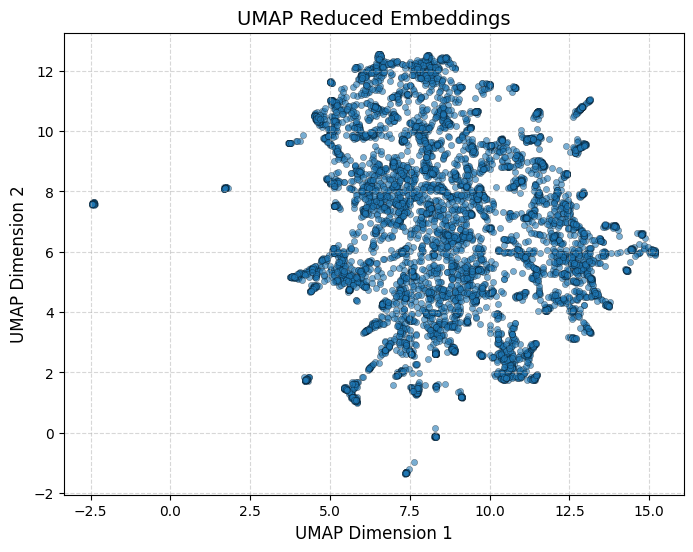

In [4]:
class UMAPReducer:
    def __init__(self, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean'):
        self.reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)

    def fit_transform(self, embeddings):
        return self.reducer.fit_transform(embeddings)

    def plot_embeddings(self, reduced_embeddings, save_path=None):
        plt.figure(figsize=(8, 6))

        plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
            s=20, alpha=0.6, edgecolors="k", linewidth=0.3, label="Documents"
        )

        plt.title('UMAP Reduced Embeddings', fontsize=14)
        plt.xlabel("UMAP Dimension 1", fontsize=12)
        plt.ylabel("UMAP Dimension 2", fontsize=12)

        plt.grid(True, linestyle="--", alpha=0.5)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Saved UMAP plot at: {save_path}")

        plt.show()


umap_reducer = UMAPReducer()
doc_embeddings_reduced = umap_reducer.fit_transform(doc_embeddings)

shuffle_indices = np.random.permutation(len(doc_embeddings_reduced)) # KEY STEP
doc_embeddings_reduced = doc_embeddings_reduced[shuffle_indices]

np.save(os.path.join(data_dir, "doc_embeddings_reduced.npy"), doc_embeddings_reduced)

_ = umap_reducer.plot_embeddings(doc_embeddings_reduced)

In [5]:
class ClassicalClustering:
    def __init__(self, k_range=[10, 25, 50, 75, 100], metric='euclidean'):
        self.k_range = k_range
        self.metric = metric
    
    def find_optimal_k(self, embeddings):
        best_score, best_k, best_labels, best_medoid_indices = float('inf'), None, None, None
        for k in self.k_range:
            model = KMedoids(n_clusters=k, metric=self.metric, random_state=42)
            labels = model.fit_predict(embeddings)
            score = davies_bouldin_score(embeddings, labels)
            if score < best_score:
                best_score, best_k, best_labels, best_medoid_indices = score, k, labels, model.medoid_indices_
        return best_labels, best_medoid_indices
    
    def extract_medoids(self, embeddings, medoid_indices):
        return embeddings[medoid_indices]

In [6]:
clustering = ClassicalClustering()
kmedoid_labels, medoid_indices = clustering.find_optimal_k(doc_embeddings_reduced)
medoid_embeddings = clustering.extract_medoids(doc_embeddings_reduced, medoid_indices)
np.save(os.path.join(data_dir, "medoid_embeddings.npy"), medoid_embeddings)
np.save(os.path.join(data_dir, "medoid_indices.npy"), medoid_indices)

In [7]:
print("Medoid Indices Shape:", medoid_indices.shape)
print("First 10 Medoid Indices:", medoid_indices[:10])

print("Medoid Embeddings Shape:", medoid_embeddings.shape)
print("First 5 Medoid Embeddings:\n", medoid_embeddings[:5])

Medoid Indices Shape: (10,)
First 10 Medoid Indices: [ 131 2476 4030 6272  183 6317 5743 2004 4385  809]
Medoid Embeddings Shape: (10, 2)
First 5 Medoid Embeddings:
 [[ 5.035855   5.4170427]
 [ 8.347165  11.145649 ]
 [ 8.837036   7.756853 ]
 [ 6.576886   7.8748894]
 [ 7.246287   2.6207738]]


In [8]:
len(medoid_indices)

10

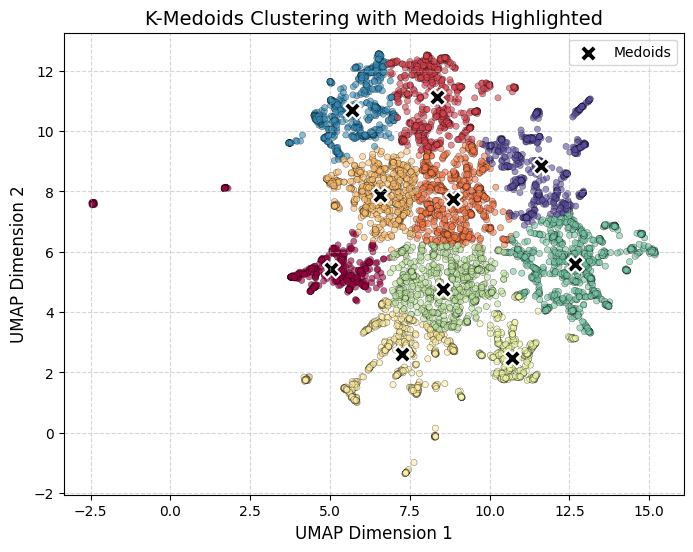

In [9]:
plt.figure(figsize=(8, 6))

plt.scatter(
    doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], 
    c=kmedoid_labels, cmap="Spectral", 
    s=20, alpha=0.6, edgecolors="k", linewidth=0.3,
)

plt.scatter(
    medoid_embeddings[:, 0], medoid_embeddings[:, 1], 
    c='black', marker='X', s=150, label="Medoids", edgecolors="white", linewidth=1.5
)

plt.title("K-Medoids Clustering with Medoids Highlighted", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

plt.legend(loc="upper right", fontsize=10, frameon=True)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [10]:
np.random.shuffle(doc_embeddings_reduced)

In [19]:
def to_upper_triangular(M):
    """Convert the matrix to an upper triangular form required for QUBO."""
    diag = np.diag(M)
    diagM = np.diag(diag)

    M1 = M - diagM
    M2 = np.triu(M1)
    M2 *= 2

    return M2 + diagM


def matrix_to_dict(M):
    """Convert a QUBO matrix to a dictionary format required by D-Wave solvers."""
    q = {}
    for i in range(len(M)):
        for j in range(i, len(M)):
            if M[i, j] != 0:
                q[(i, j)] = M[i, j]
    return q


class QuboSolver:
    def __init__(self, qubo_dict, n_clusters, num_reads=100):
        self.qubo_dict = qubo_dict
        self.n_clusters = n_clusters
        self.num_reads = num_reads

    def run_QuboSolver(self):
        sampler = SimulatedAnnealingSampler()
        bqm = dmd.BinaryQuadraticModel.from_qubo(self.qubo_dict)
        response = sampler.sample(bqm, num_reads=self.num_reads)
        print("Raw QUBO Response:", response.first.sample)
        best_sample = response.first.sample
        return self._decode_clusters(best_sample)

    def _decode_clusters(self, sample):
        """Extract cluster indices from QUBO solution."""
        cluster_indices = [i for i, v in sample.items() if v == 1]
        if len(cluster_indices) == 0:
            print("Warning: No valid medoid indices selected by QUBO Solver.")
        print("Decoded Medoid Indices:", cluster_indices)
        return np.array(cluster_indices, dtype=int)


class QuantumClustering:
    def __init__(self, k_range):
        self.k_range = k_range

    def compute_corrloss(self, data):
        """Compute normalized correntropy loss for QUBO matrix."""
        D = distance.squareform(distance.pdist(data, metric='euclidean'))
        
        W = 1 - np.exp(-D / (np.max(D) + 1e-5))
        return W

    def build_qubo_matrix(self, medoid_embeddings):
        """Build QUBO matrix with penalty terms (α, β, γ)."""
        N = len(medoid_embeddings)
        alpha = 1 / N * 1/2
        beta = 1 / N * 1/3
        gamma = 2

        W = self.compute_corrloss(medoid_embeddings)
        Q = gamma - alpha * W / 2

        for i in range(N):
            Q[i, i] += beta * np.sum(W[i]) - 2 * gamma * len(medoid_embeddings)

        Q = to_upper_triangular(Q)
        dictQ = matrix_to_dict(Q)

        # Print debugging info
        print(f"Penalty terms - α: {alpha}, β: {beta}, γ: {gamma}")
        print(f"QUBO Matrix Min: {np.min(Q)}, Max: {np.max(Q)}, Mean: {np.mean(Q)}")
        print(f"QUBO Matrix Sample:\n{Q[:5, :5]}")

        return dictQ

    def solve_qubo(self, qubo_dict):
        """Select medoids using QUBO and compute silhouette score."""
        best_dbi = float("inf")
        best_k = None
        best_refined_medoid_indices = None

        silhouettes_quantum = {}

        print(f"Starting QUBO solving. Current best DBI={best_dbi}")

        for k in self.k_range:
            print(f"Solving QUBO for k={k}")

            solver = QuboSolver(qubo_dict, k)
            refined_medoid_indices = solver.run_QuboSolver()

            print(f"Refined medoid indices from QUBO Solver: {refined_medoid_indices}")

            if refined_medoid_indices is None or len(refined_medoid_indices) == 0:
                print(f"Warning: No valid medoids found for k={k}. Skipping DBI computation.")
                continue

            final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
            
            silhouettes_quantum[k] = silhouette_score(doc_embeddings_reduced, final_cluster_labels)

            dbi = davies_bouldin_score(doc_embeddings_reduced, final_cluster_labels)

            if dbi < best_dbi:
                best_dbi = dbi
                best_k = k
                best_refined_medoid_indices = refined_medoid_indices

        print(f"Selected k={best_k} with DBI={best_dbi}")
        return np.array(best_refined_medoid_indices), silhouettes_quantum


def compute_clusters(data, medoid_indices):
    """Assign each point to the closest medoid."""
    if len(medoid_indices) == 0:
        raise ValueError("No medoids selected. QUBO Solver likely failed. Investigate `refined_medoid_indices` output.")

    print(f"Medoid indices: {medoid_indices}")
    print(f"Medoid embeddings shape: {data[medoid_indices].shape}")

    distances = pairwise_distances(data, data[medoid_indices], metric='euclidean')
    return np.argmin(distances, axis=1)

In [20]:
k_range = [2, 3, 4, 5, 6, 7, 8, 9]
quantum_clustering = QuantumClustering(k_range)

qubo_dict = quantum_clustering.build_qubo_matrix(medoid_embeddings)

refined_medoid_indices, silhouettes_quantum = quantum_clustering.solve_qubo(qubo_dict)

final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
refined_medoid_embeddings = doc_embeddings_reduced[refined_medoid_indices]

np.save(os.path.join(data_dir, "final_quantum_clusters.npy"), final_cluster_labels)
np.save(os.path.join(data_dir, "refined_medoid_embeddings.npy"), refined_medoid_embeddings)
np.save(os.path.join(data_dir, "refined_medoid_indices.npy"), refined_medoid_indices)

Penalty terms - α: 0.05, β: 0.03333333333333333, γ: 2
QUBO Matrix Min: -37.8995574142325, Max: 3.9895173700673423, Mean: -1.9969359919506156
QUBO Matrix Sample:
[[-37.87519163   3.97513223   3.98143723   3.98698228   3.98451761]
 [  0.         -37.86994341   3.98502514   3.98396699   3.97045911]
 [  0.           0.         -37.89955741   3.98951737   3.97859006]
 [  0.           0.           0.         -37.89304173   3.97882942]
 [  0.           0.           0.           0.         -37.87071608]]
Starting QUBO solving. Current best DBI=inf
Solving QUBO for k=2
Raw QUBO Response: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Decoded Medoid Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Refined medoid indices from QUBO Solver: [0 1 2 3 4 5 6 7 8 9]
Medoid indices: [0 1 2 3 4 5 6 7 8 9]
Medoid embeddings shape: (10, 2)
Solving QUBO for k=3
Raw QUBO Response: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Decoded Medoid Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Refined 

It keeps choosing 0, 1, 2, 3, 4, 5, 6, 7

In [13]:
final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
print("Sample cluster assignments:", final_cluster_labels[:20])

Medoid indices: [0 1 2 3 4 5 6 7]
Medoid embeddings shape: (8, 2)
Sample cluster assignments: [0 1 2 3 4 5 6 7 4 2 6 6 6 0 6 4 6 2 1 2]


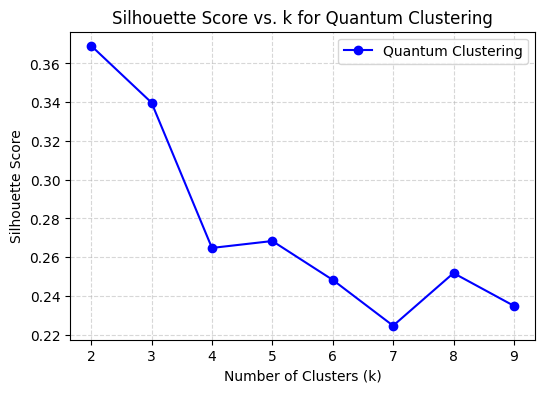

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(list(silhouettes_quantum.keys()), list(silhouettes_quantum.values()), marker='o', linestyle='-', color='blue', label="Quantum Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k for Quantum Clustering")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

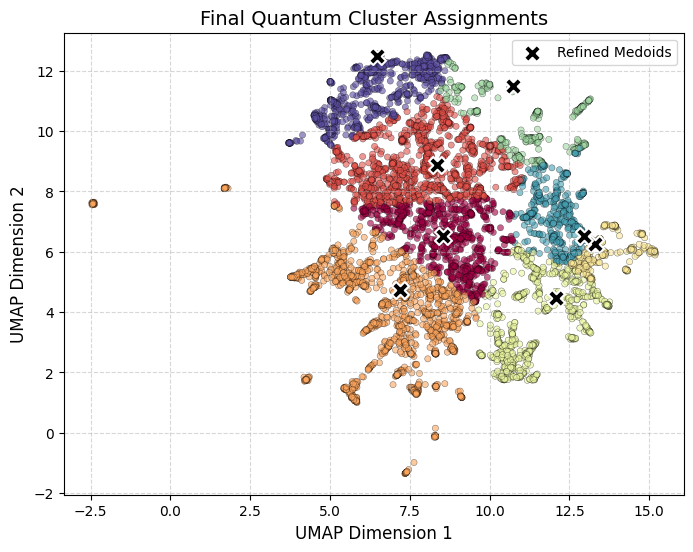

In [15]:
plt.figure(figsize=(8, 6))

plt.scatter(
    doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], 
    c=final_cluster_labels, cmap="Spectral", 
    s=20, alpha=0.6, edgecolors="k", linewidth=0.3
)

plt.scatter(
    doc_embeddings_reduced[refined_medoid_indices, 0], 
    doc_embeddings_reduced[refined_medoid_indices, 1], 
    c='black', marker='X', s=150, 
    edgecolors="white", linewidth=1.5, label="Refined Medoids"
)

plt.title("Final Quantum Cluster Assignments", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

plt.legend(loc="upper right", fontsize=10, frameon=True)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

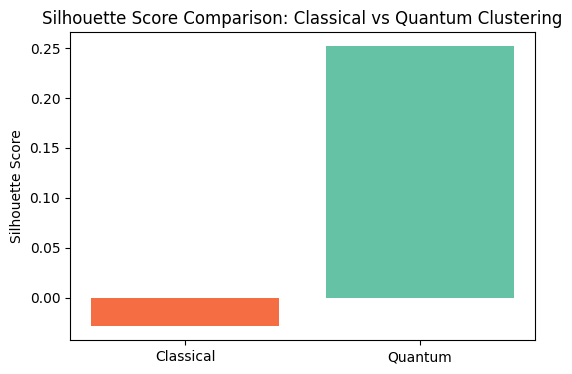

Silhouette Score - Classical: -0.028719350695610046, Quantum: 0.25175759196281433


In [16]:
silhouette_q = silhouette_score(doc_embeddings_reduced, final_cluster_labels)
silhouette_c = silhouette_score(doc_embeddings_reduced, kmedoid_labels)

spectral_cmap = cm.get_cmap("Spectral")
colors = [spectral_cmap(0.2), spectral_cmap(0.8)]

plt.figure(figsize=(6, 4))
plt.bar(["Classical", "Quantum"], [silhouette_c, silhouette_q], color=colors)
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Comparison: Classical vs Quantum Clustering")

plt.show()

print(f"Silhouette Score - Classical: {silhouette_c}, Quantum: {silhouette_q}")